In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pylab as plt

from sklearn.cluster import KMeans
import napari

from image_analysis.read_files import get_paths, change_paths
from image_analysis.fit import plot, roi, regionprops
from image_analysis.preprocess import mask

In [3]:
pixel_size = 2

In [4]:
pc = 50

In [5]:
folder_pretreated = r'/home/natalia/Documents/github_image_analysis/experimental_data/treatment_all/'
df = pd.read_excel("../images.xlsx")

In [6]:
df_to_plot = df[df['Animal size, cm'] == 3]

In [7]:
df_to_plot

,Sample name,HCR,"Animal size, cm","Regeneration time, dpa","Exact animal size (snout to tail), cm","Average animal size inside each group, cm",Unnamed: 6,Unnamed: 7
23,hcr22_2_5cm_4d_t1b,22,3,4,3.2,3.175,NaN,NaN
24,hcr22_2_5cm_4d_t1a,22,3,4,3.2,NaN,NaN,NaN
25,hcr21_2_5cm_5dpa_p_hist,21,3,5,2.9,NaN,NaN,NaN
26,hcr22_2_5cm_5d_t2a,22,3,5,2.9,NaN,NaN,NaN
27,hcr21_2_5cm_6dpa_noif,21,3,6,2.7,NaN,NaN,NaN
28,hcr21_2_5cm_6dpa_p_hist,21,3,6,2.7,NaN,NaN,NaN
29,hcr21_2_5cm_7dpa_noif,21,3,7,2.9,NaN,NaN,NaN


# Find plane to show: trough SF closest to p1p2

In [8]:
keys_dpa = set( [str(h) for h in df_to_plot['Regeneration time, dpa'].values] )
keys_dpa

{'4', '5', '6', '7'}

# Orient all

In [9]:
ex = np.array([0,0,1])
ey = np.array([0,-1,0])
ez = np.cross(ex, ey)

In [10]:
img = dict.fromkeys(keys_dpa, 0)

for tkey in keys_dpa:
    
    df_t  = df_to_plot[df_to_plot['Regeneration time, dpa'] == int(tkey)]
    df_t  = df_t.reset_index(drop=True)
    nkeys = [str(i+1) for i in range(0, len(df_t))]
    img[tkey]  = dict.fromkeys(nkeys, 0)

    for index, row in df_t.iterrows():
        
        print(row['Sample name'])
        
        path = row['Sample name']
        keys = np.load( os.path.join(folder_pretreated, path + '_keys.npy') )
        
        image = dict(
            zip(
                keys, 
                np.load( os.path.join(folder_pretreated, path + '.npy') )
            )
        )

        if f'dusp{pc}_clip' in keys:
            image = dict(zip(
                ['shh_mask', 'dusp_mask', 'fgf_mask', 'tissue_mask_with_epi'],
                [ (image[f'shh{pc}_clip'] > 0).astype(int),  (image[f'dusp{pc}_clip']>0).astype(int), (image[f'fgf{pc}_clip']>0).astype(int), image['tissue_mask_with_epi'] ]
            ))
        else:
            image = dict(zip(
                ['shh_mask', 'dusp_mask', 'fgf_mask', 'tissue_mask_with_epi'],
                [ (image[f'shh{pc}_clip'] > 0).astype(int),  0*(image[f'shh{pc}_clip']>0).astype(int), (image[f'fgf{pc}_clip']>0).astype(int), image['tissue_mask_with_epi'] ]
            ))  
        
        image['shh_mask'] = mask.largest_component( image['shh_mask'] )
        image['dusp_mask'] = mask.few_largest_components( image['dusp_mask'], 2 )
        image['fgf_mask'] = mask.few_largest_components( image['fgf_mask'], 2 )

        # align

        regionprops_3d = regionprops.regionprops_3d(image, 1, 1, 1, pixel_size)
        regionprops_3d.center_mass(['shh_mask', 'fgf_mask'])
        regionprops_3d.tensor_inertia('tissue_mask_with_epi')

        if row['Sample name'] not in ['hcr21_lb68_fr', 'hcr21_lb66_fr']:
            image = regionprops_3d.rotate_N_desired_to_ez()
        else:
            image = regionprops_3d.rotate_N_desired_to_ez_special()
                    
        S = np.array( regionprops.center_mass( image['shh_mask'] ) )
        F = np.array( regionprops.center_mass( image['fgf_mask'] ) )
        SF = F - S
        
        print(S[0], F[0])
        
        # z-slice
        for key in image.keys():
            image[key] = image[key][:, F[1], :]
            
            if 'mask' in key:
                image[key] = (image[key] > 0) * 1
        img[tkey][str(index+1)] = dict(zip([path], [image]))

hcr22_2_5cm_4d_t1b


/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/regionprops.py:24: RuntimeWarning: Mean of empty slice
  img_arr_x = np.nanmean(np.nanmean(img_arr, axis=0), axis=0)
/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/regionprops.py:27: RuntimeWarning: Mean of empty slice
  img_arr_y = np.nanmean(np.nanmean(img_arr, axis=0), axis=1)
/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/regionprops.py:30: RuntimeWarning: Mean of empty slice
  img_arr_z = np.nanmean(np.nanmean(img_arr, axis=1), axis=1)
/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/regionprops.py:24: RuntimeWarning: Mean of empty slice
  img_arr_x = np.nanmean(np.nanmean(img_arr, axis=0), axis=0)
/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/regionprops.py:27: RuntimeWarning: Mean of empty slice
  img_arr_y = np.nanmean(np.nanmean(img_arr, axis=0), axis=1)
/home/natalia/D

Angle between ez and N_desired: -1
65 63
hcr22_2_5cm_4d_t1a
Angle between ez and N_desired: -20
Re-running the rotation function due to insufficient alignment
Angle between ez and N_desired: 3
61 66
hcr21_2_5cm_7dpa_noif
Angle between ez and N_desired: 11
86 87
hcr21_2_5cm_5dpa_p_hist
Angle between ez and N_desired: 1
62 62
hcr22_2_5cm_5d_t2a
Angle between ez and N_desired: -21
Re-running the rotation function due to insufficient alignment
Angle between ez and N_desired: 3
83 89
hcr21_2_5cm_6dpa_noif
Angle between ez and N_desired: 0
83 82
hcr21_2_5cm_6dpa_p_hist
Angle between ez and N_desired: -2
104 98


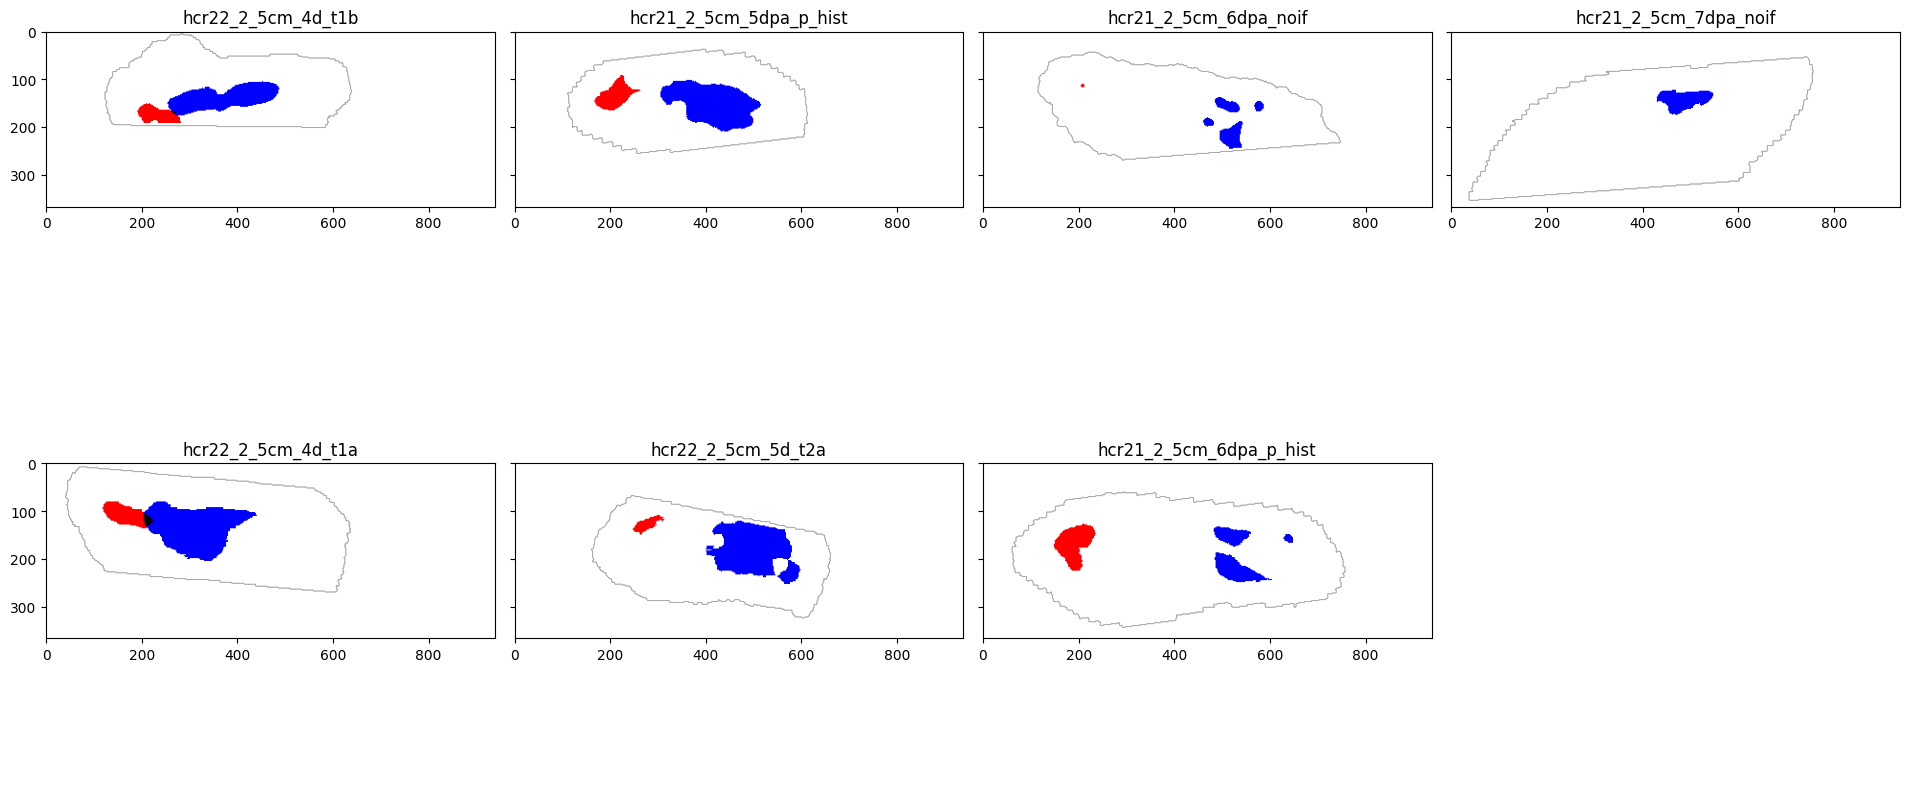

In [11]:
plot.shh_fgf_red_blue(img, pixel_size, 'shh_mask', 'fgf_mask', 100)
plt.show()

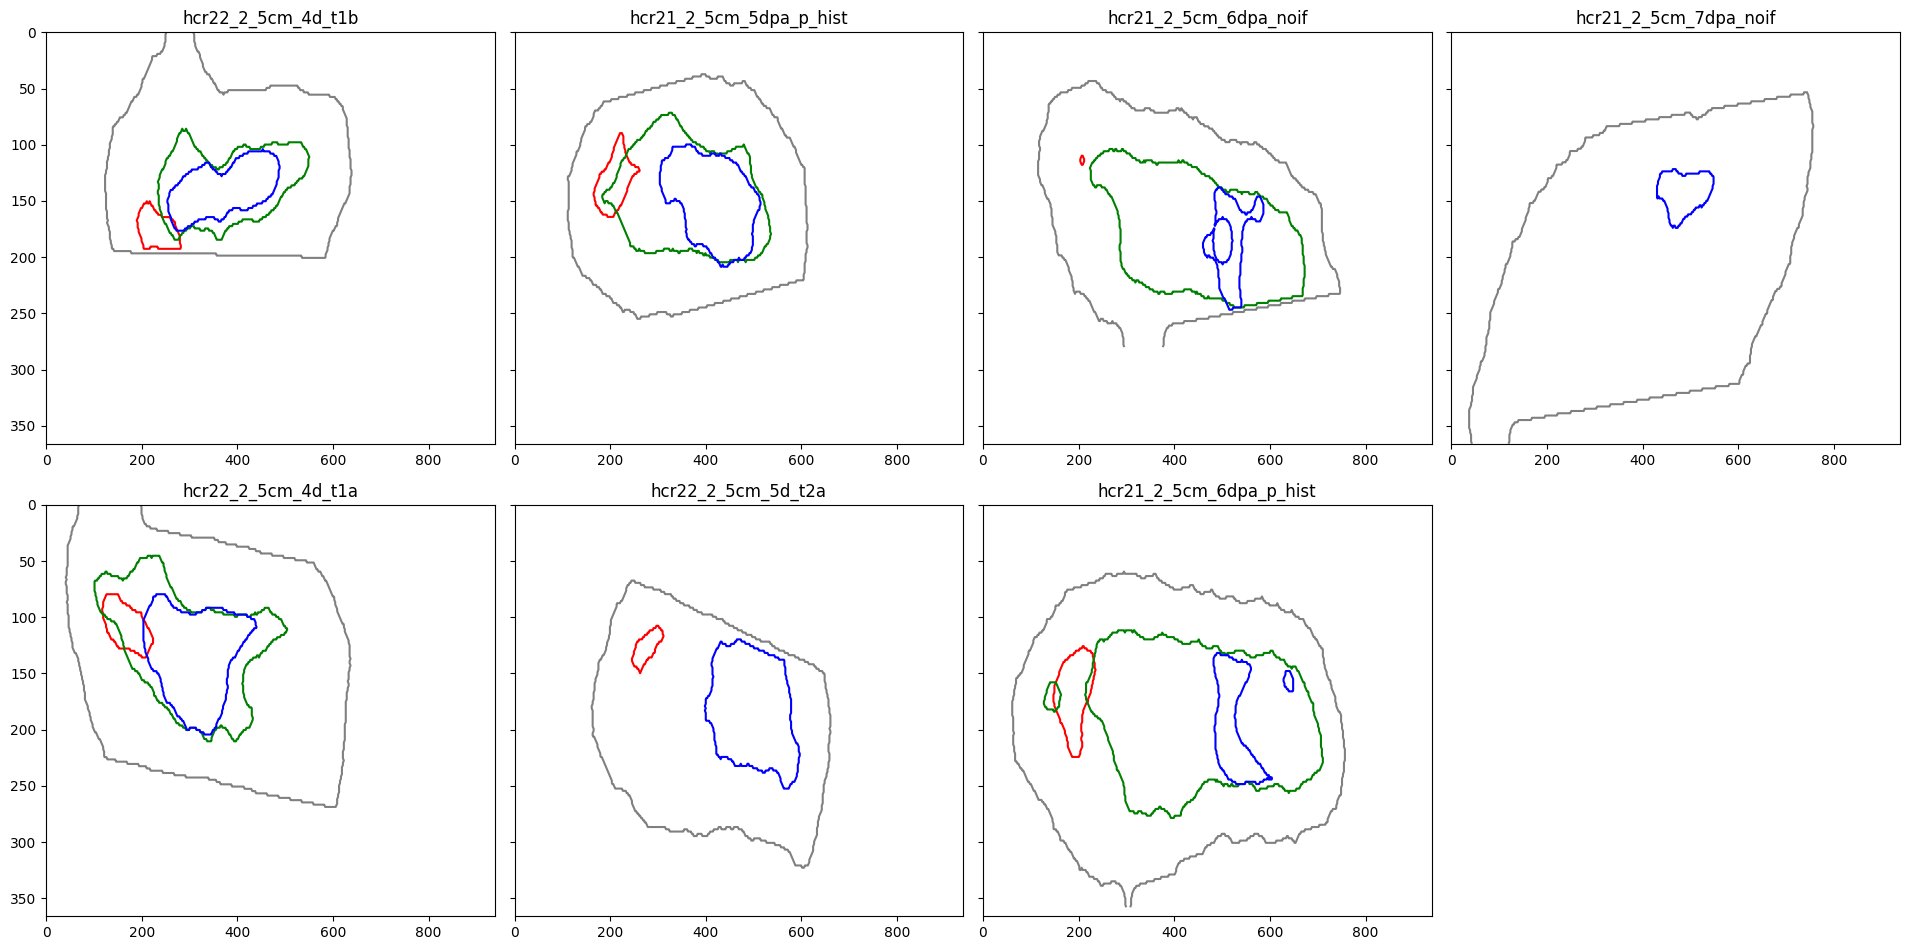

In [12]:
plot.shh_dusp_fgf_rgb(img, pixel_size, 'shh_mask', 'dusp_mask', 'fgf_mask', 100)
plt.show()